# Ranting about $K_d$

In [1]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from ocpy.hydrolight import loisel23
from ocpy.utils import plotting as oc_plotting
from ocpy.satellites import pace as sat_pace
from ocpy.water import absorption as water_abs

from bing.models import anw as boring_anw
from bing.models import bbnw as boring_bbnw
from bing.models import utils as model_utils
from bing.models import functions
from bing import inference as big_inf
from bing import rt as big_rt
from bing import chisq_fit


In [2]:
%matplotlib ipympl

# Load up Loisel+2023 Hydrolight dataset

## Using the full run (inelastic scattering) at Zenith

In [3]:
ds = loisel23.load_ds(4,0)

In [4]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
all_a = ds.a.data
all_b = ds.b.data
all_bnw = ds.bnw.data
all_bbnw = ds.bbnw.data
all_bb = ds.bb.data
all_adg = ds.ag.data + ds.ad.data
all_ad = ds.ad.data
all_ag = ds.ag.data
all_aph = ds.aph.data
all_anw = ds.anw.data
#
all_bw = all_b - all_bnw
#
all_bbd = ds.bbd.data
all_bbph = ds.bbph.data

In [12]:
ds_profile = loisel23.load_ds(4,0, profile=True)
all_Kd = ds_profile.KEd_z[1,:,:]
all_Kd.shape

(3320, 81)

In [5]:
l23_aw = all_a[0] - all_anw[0]
l23_bbw = all_bb[0] - all_bbnw[0]

In [6]:
all_anw.shape

(3320, 81)

In [7]:
l23_wave.min(), l23_wave.max()

(350.0, 750.0)

## Setup

In [8]:
i350 = np.argmin(np.abs(l23_wave-350.))
i440 = np.argmin(np.abs(l23_wave-440.))
i750 = np.argmin(np.abs(l23_wave-750.))  # Should have been 780

In [13]:
Kd_350 = all_Kd[:,i350]
Kd_750 = all_Kd[:,i750]

In [14]:
acdom_440 = all_ag[:,i440]

## More water

In [9]:
more_wave = np.arange(320., 781., 1.)
aw = water_abs.a_water(more_wave)
#
i780 = np.argmin(np.abs(more_wave-780.))  

# Coefficients for Hooker+2013

## Express their expression as:

## $a_{\rm CDOM}(440) = H_0 \left [ \frac{K_d(320)}{K_d(780)} \right ] - H_1  \;\; [\rm m^{-1}]$

## with $H_0 = 0.293$ and $H_1 = 0.015$

# Let's derive our values from this expression:

## $a_{\rm CDOM}(320) \approx  a_w(780) \frac{K_d(320)}{K_d(780)} - 4.18 \, b_{\rm b,w}(320)$

## Starting with $H_0$

In [31]:
bb780 = 0.
H0 = aw[i780] + 4.18 * (1 - 0.52 * np.exp(-10.8*aw[i780])) * bb780
H0

2.6905

## Now $H_1$

### We will assume that water dominates back-scattering

### And that $a_{\rm CDOM}(320)$ is large enough to ignore the term in the brackets

### I don't have the Zhang MatLab code ported to Python yet (bug)

### So we'll use $b_{\rm b,w}(350)$ from L23

In [11]:
H1 = 4.18 * l23_bbw[i350]
H1

0.02473431401886046

## Now we have to reduce these by translating $a_{\rm CDOM}(320)$ to 440nm

## $a_{\rm CDOM}(440) = a_{\rm CDOM}(320) \exp[-S_{\rm CDOM}(440-320)]$

## with $S_{\rm CDOM} \approx 0.015$

In [35]:
rexp = np.exp(-0.015*120)
H0*rexp, H1*rexp

(0.44473665876017865, 0.004088554608241236)

## These are larger/smaller than the Hooker+2013 values

----

# Let's make the main plot from Hooker+2013, 2020

## Functional form

In [26]:
def acdom_hooker2013(kd_ratio):
    return 0.293 * kd_ratio - 0.015

In [21]:
Kd_ratio = Kd_350/Kd_750

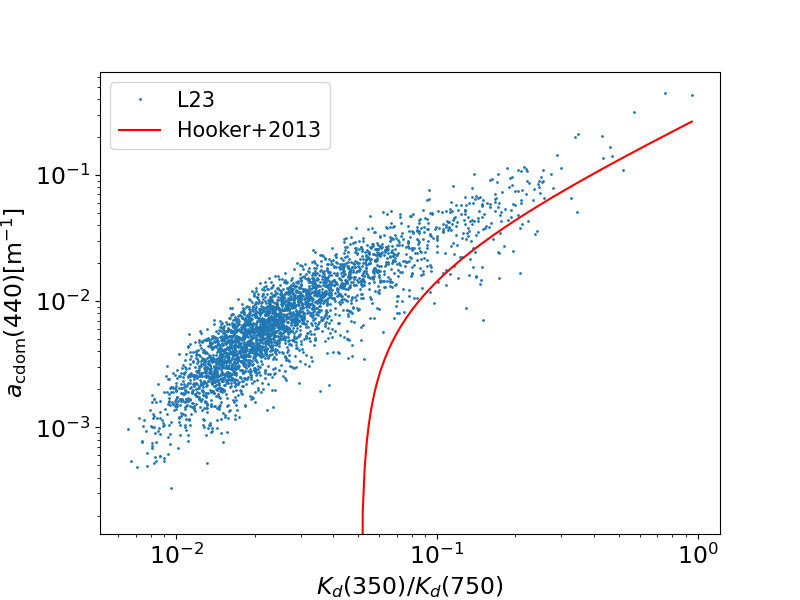

In [27]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(Kd_350/Kd_750, acdom_440, 'o', ms=1, label='L23')
#
#ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel(r'$K_d(350)/K_d(750)$')
ax.set_ylabel(r'$a_{\rm cdom}(440) [\rm m^{-1}]$')
# Hooker+2013
x = np.linspace(Kd_ratio.min(), Kd_ratio.max(), 1000) 
ax.plot(x, acdom_hooker2013(x), 'r-', label='Hooker+2013')
#
ax.legend(fontsize=15.)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

# Do my own fit..

In [28]:
# Fit a linear polynomial (degree 1)
coeffs = np.polyfit(Kd_ratio, acdom_440, 1)

# coeffs[0] is the slope, coeffs[1] is the y-intercept
slope, intercept = coeffs

print(f"Slope: {slope}")
print(f"Y-intercept: {intercept}")

Slope: 0.38482072665712774
Y-intercept: -0.0024028921334223415


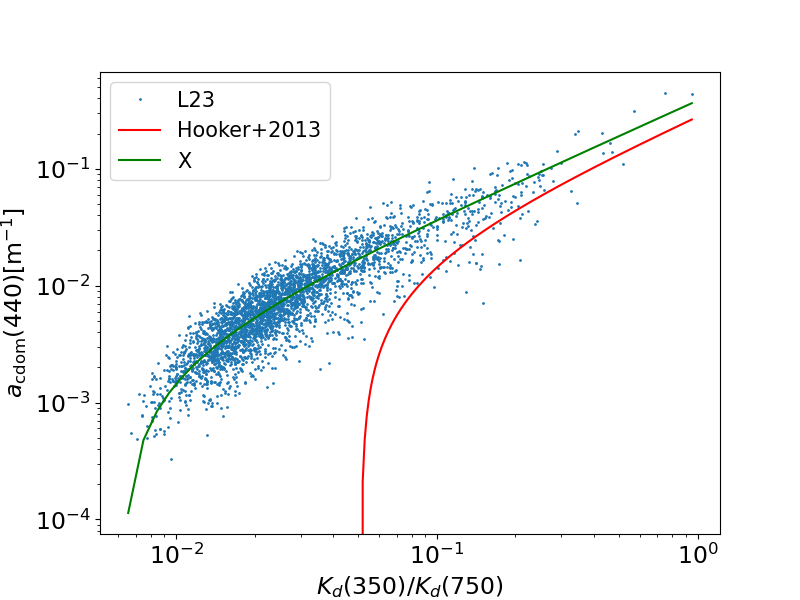

In [29]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(Kd_350/Kd_750, acdom_440, 'o', ms=1, label='L23')
#
#ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel(r'$K_d(350)/K_d(750)$')
ax.set_ylabel(r'$a_{\rm cdom}(440) [\rm m^{-1}]$')
# Hooker+2013
x = np.linspace(Kd_ratio.min(), Kd_ratio.max(), 1000) 
ax.plot(x, acdom_hooker2013(x), 'r-', label='Hooker+2013')
# My fit
ax.plot(x, slope*x + intercept, 'g-', label='X')
#
ax.legend(fontsize=15.)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

# And how about what I derived??

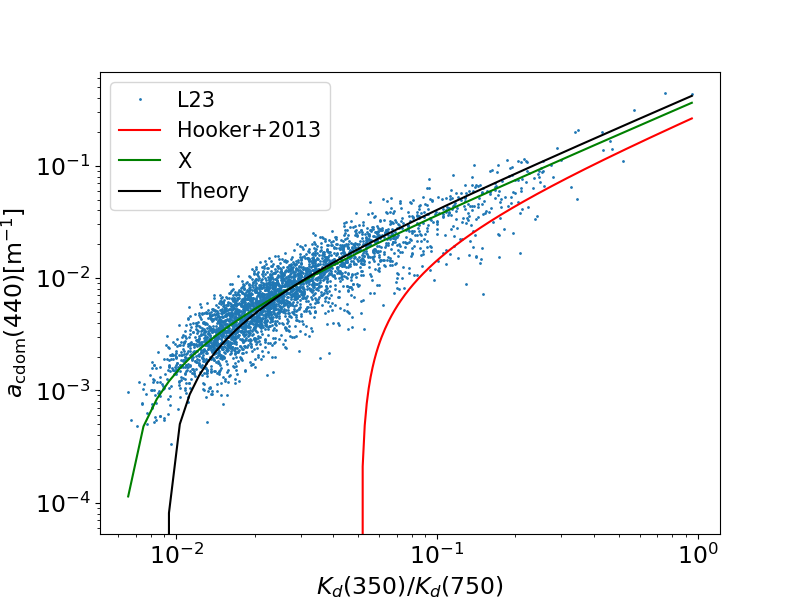

In [36]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(Kd_350/Kd_750, acdom_440, 'o', ms=1, label='L23')
#
#ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel(r'$K_d(350)/K_d(750)$')
ax.set_ylabel(r'$a_{\rm cdom}(440) [\rm m^{-1}]$')
# Hooker+2013
x = np.linspace(Kd_ratio.min(), Kd_ratio.max(), 1000) 
ax.plot(x, acdom_hooker2013(x), 'r-', label='Hooker+2013')
# My fit
ax.plot(x, slope*x + intercept, 'g-', label='X')
# Derivation
ax.plot(x, H0*rexp*x - H1*rexp, 'k-', label='Theory')
#
ax.legend(fontsize=15.)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

# What is $a_{\rm cdom}/a_{\rm nw}$??

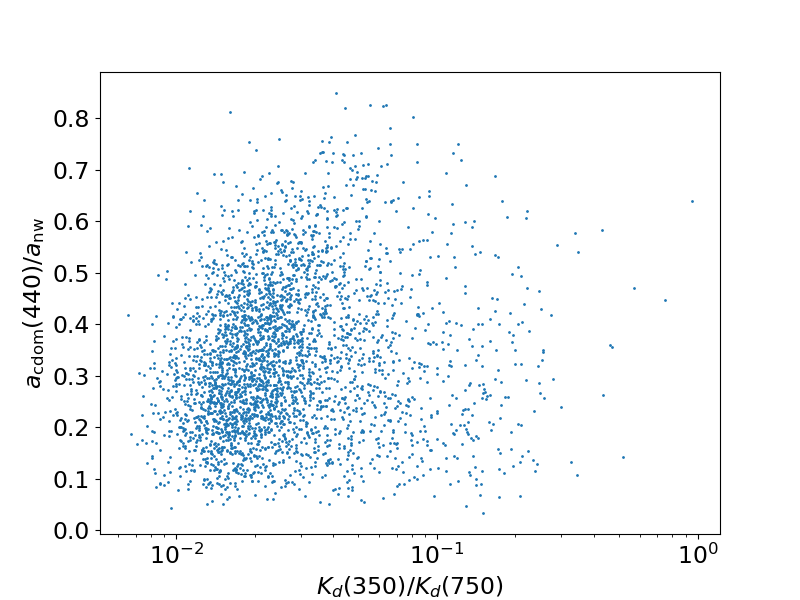

In [34]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.plot(Kd_ratio, acdom_440/all_anw[:,i440], 'o', ms=1, label='L23')
#
#ax.legend(fontsize=15.)
oc_plotting.set_fontsize(ax, 17.)
# Label
ax.set_xlabel(r'$K_d(350)/K_d(750)$')
ax.set_ylabel(r'$a_{\rm cdom}(440)/a_{\rm nw}$') 
#
#ax.legend(fontsize=15.)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()